In [1]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#modeling
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

np.random.seed(123)

### Univariate time series 
* ARIMA: combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I). AR(p), I(d), and MA(q) models as parameters
* ARIMA(data, order=(1, 1, 1))

* SARIMA: combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level. SARIMA(p, d, q)(P, D, Q)m where  AR(P), I(D), MA(Q) and m parameters at the seasonal level, “m” is the number of time steps in each season (the seasonal period)
* SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))

* SARIMAX: Exogenous variables are also called covariates and can be thought of as parallel input sequences that have observations at the same time steps as the original series.  
* SARIMAX(data1, exog=data2, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))

In [2]:
df = DataReader('AAL', data_source='yahoo', start='2012-01-01', end=datetime.now())

In [3]:
data = df.filter(['Close'])

In [4]:
dataset = data.values

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_data = scaled_data[0:int(training_data_len), :]

In [7]:
train_data.shape

(2193, 1)

## ARISM

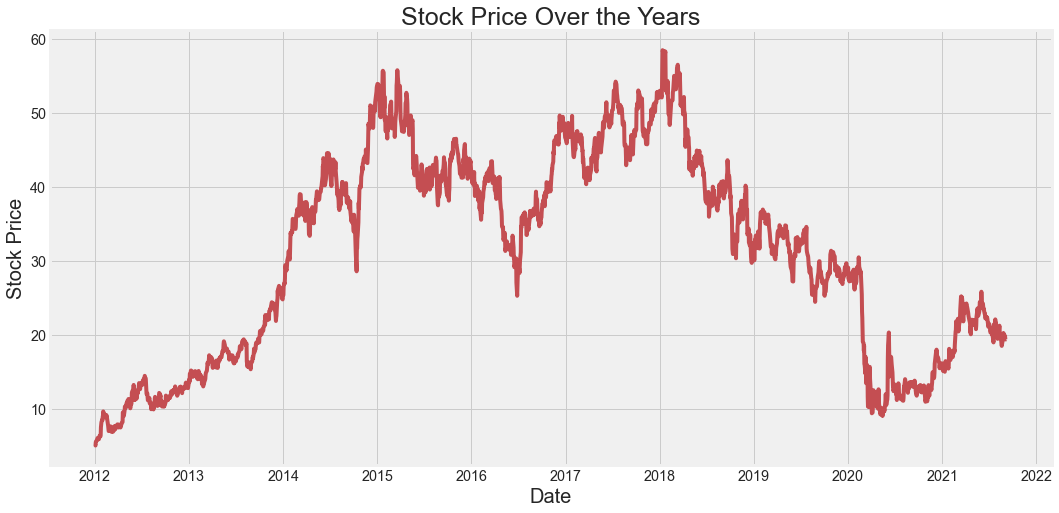

In [8]:
plt.figure(figsize=(16,8))
plt.plot(data['Close'], label='Close.',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Over the Years',size=25);

In [9]:
def adfuller_test(stocks):
    result=adfuller(stocks)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

In [10]:
adfuller_test(data)

ADF Test Statistic : -2.026247537302176
p-value : 0.27518435348021164
#Lags Used : 1
Number of Observations : 2434


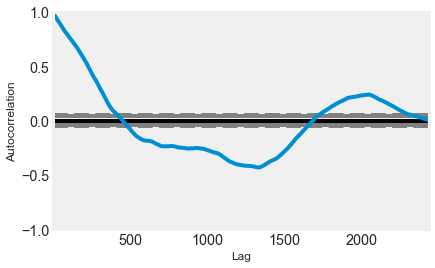

In [11]:
autocorrelation_plot(data['Close'])
plt.show()

In [12]:
data['Close First diff'] = data['Close'] - data['Close'].shift(1)
data['Close Seasonal diff']=data['Close']- data['Close'].shift(12)
data.head()

,Close,Close First diff,Close Seasonal diff
Date,,,
2012-01-03,5.12,NaN,NaN
2012-01-04,5.03,-0.09,NaN
2012-01-05,5.47,0.44,NaN
2012-01-06,5.60,0.13,NaN
2012-01-09,5.72,0.12,NaN


In [13]:
adfuller_test(data['Close Seasonal diff'].dropna())

#rejecting the null hypothesis. So data is stationary.

ADF Test Statistic : -7.823072114853398
p-value : 6.590774003331147e-12
#Lags Used : 24
Number of Observations : 2399


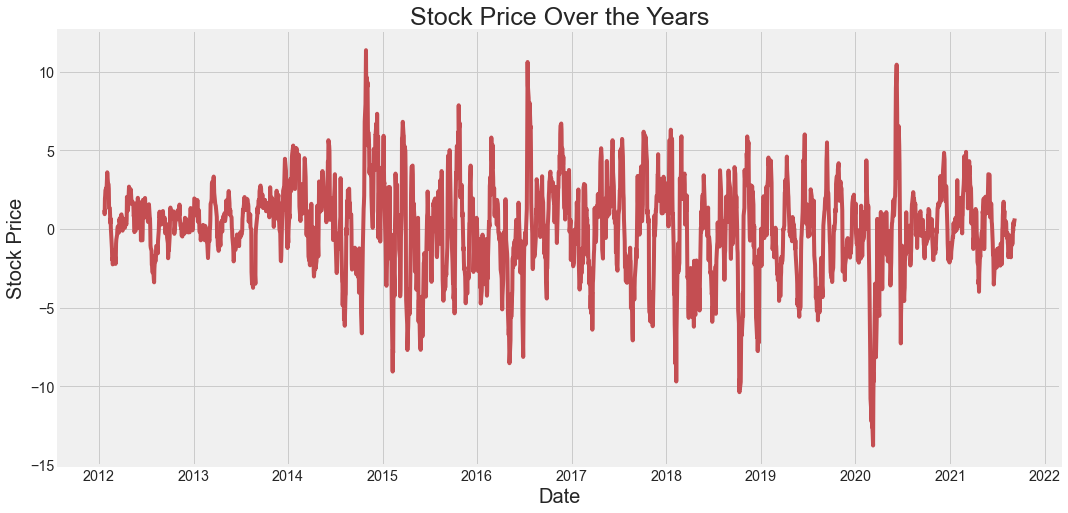

In [14]:
plt.figure(figsize=(16,8))
plt.plot(data['Close Seasonal diff'], label='Close Seasonal Diff.',color='r')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Over the Years',size=25);

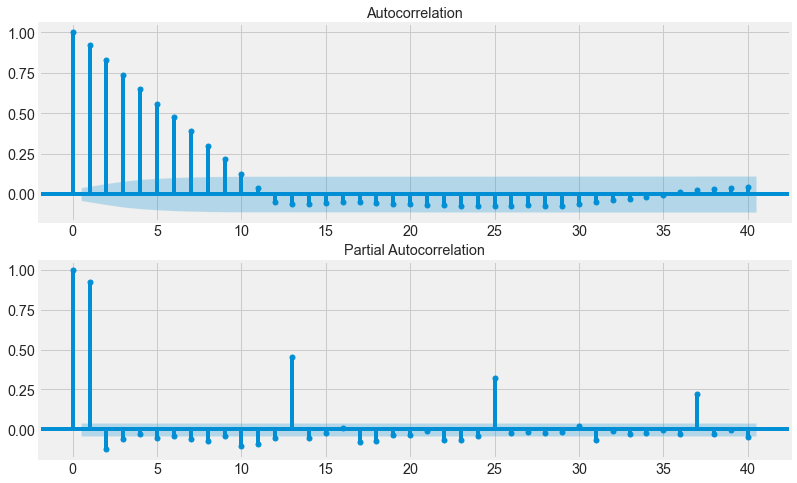

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Close Seasonal diff'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Close Seasonal diff'].dropna(),lags=40,ax=ax2)

No handles with labels found to put in legend.


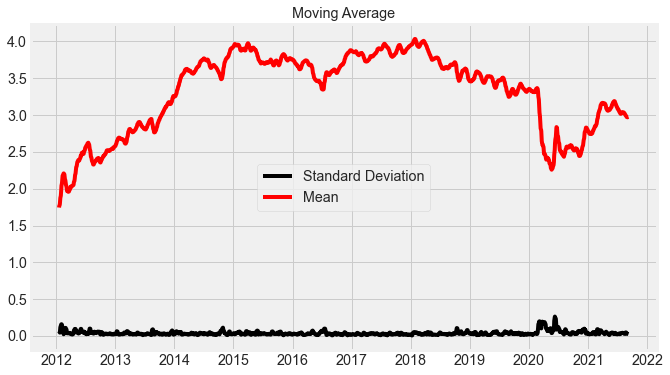

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

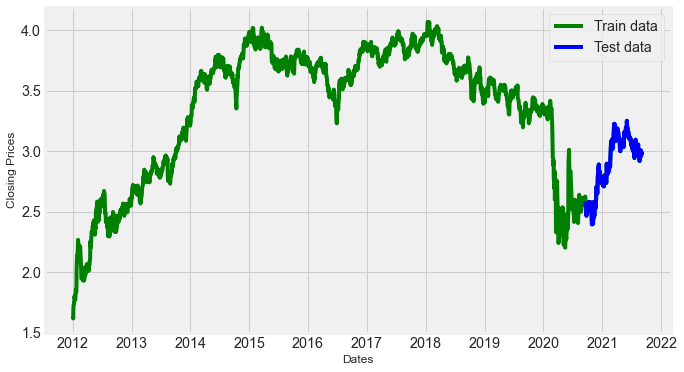

In [17]:
train_data, test_data = df_log[0:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [18]:
len(test_data)

244

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8941.491, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8962.246, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8962.743, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8943.047, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8960.752, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8960.757, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8958.784, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8964.379, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8962.386, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8962.311, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8963.887, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8960.416, Time=0.19 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.077 seconds
                               SARIMAX Results                              

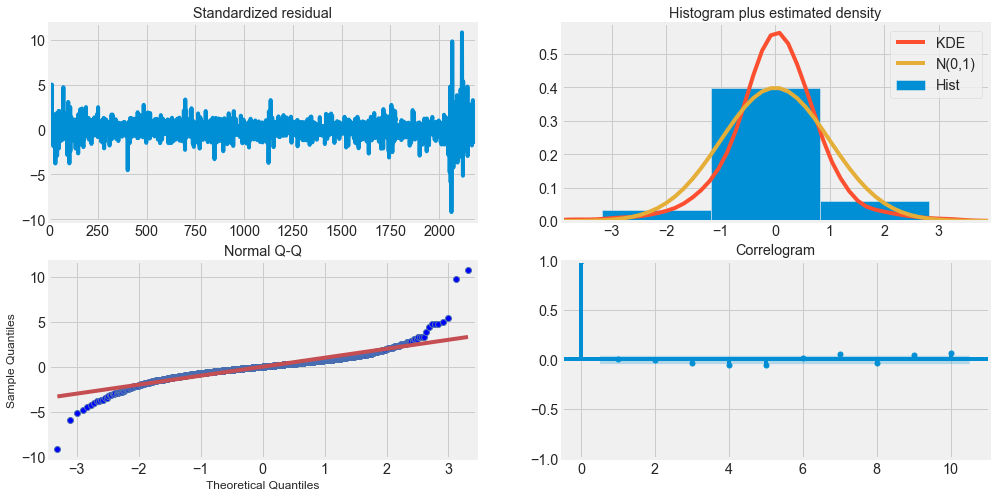

In [19]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=9, max_q=9, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

1. The top left plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

In [20]:
#The best ARIMA model with p,d,q values is 0,1,1 and Seasonal P,D,Q with 0,0,0

model = ARIMA(train_data, order=(0,1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2191
Model:                 ARIMA(0, 1, 1)   Log Likelihood                4484.372
Method:                       css-mle   S.D. of innovations              0.031
Date:                Tue, 07 Sep 2021   AIC                          -8962.744
Time:                        10:40:29   BIC                          -8945.667
Sample:                             1   HQIC                         -8956.502
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.001      0.604      0.546      -0.001       0.002
ma.L1.D.Close     0.1035      0.021      4.873      0.000       0.062       0.145
                                    Root

In [21]:
fc, se, conf = fitted.forecast(244, alpha=0.05)  #95% conf

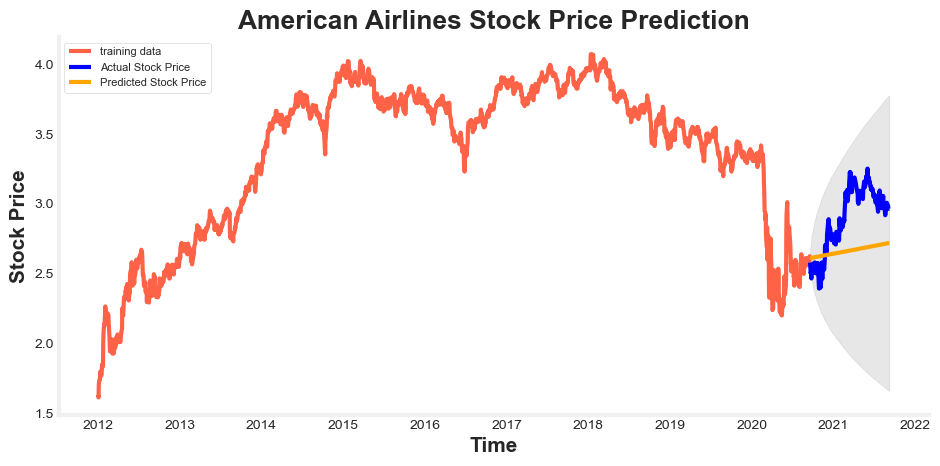

In [30]:
# Make as pandas series

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
with plt.style.context('images/presentation.mplstyle'):
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training data')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.10)
    plt.title('American Airlines Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend(loc='upper left', fontsize=8)
#plt.savefig('images/ARIMA.png')

    


In [23]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.09963631250197567
MAE: 0.2782287635785603
RMSE: 0.3156522018012478
MAPE: 0.09277646209923258


predicted=13.627711, expected=13.190000
predicted=13.146377, expected=12.210000
predicted=12.146651, expected=12.340000
predicted=12.352078, expected=11.930000
predicted=11.929090, expected=11.770000
predicted=11.762564, expected=12.290000
predicted=12.344455, expected=12.760000
predicted=12.801545, expected=12.250000
predicted=12.212959, expected=12.290000
predicted=12.283478, expected=12.580000
predicted=12.608828, expected=13.000000
predicted=13.029834, expected=13.120000
predicted=13.131604, expected=12.530000
predicted=12.483223, expected=13.070000
predicted=13.101887, expected=13.160000
predicted=13.181179, expected=13.200000
predicted=13.195186, expected=12.920000
predicted=12.906275, expected=12.220000
predicted=12.168498, expected=12.360000
predicted=12.374824, expected=12.230000
predicted=12.240254, expected=12.460000
predicted=12.478941, expected=12.560000
predicted=12.579121, expected=12.800000
predicted=12.814371, expected=12.750000
predicted=12.749350, expected=13.150000


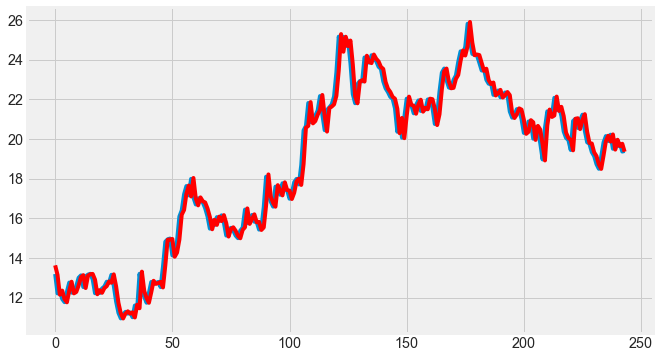

In [24]:
from matplotlib import pyplot

size = int(len(dataset) * 0.9)
train, test = dataset[0:size], dataset[size:len(dataset)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_st = df.ix[:-24, "station"]
test_st = df.ix[-24:, "station"]
sarima_model = SARIMAX(train_st, order=(0, 1, 2), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction("1974-01", "1975-12")
predicted_means = p.predicted_mean + df.data.iloc[-36:-1].rolling(12).mean().dropna().values
predicted_intervals = p.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + df.data.iloc[-36:-1].rolling(12).mean().dropna().values
upper_bounds = predicted_intervals['upper station'] + df.data.iloc[-36:-1].rolling(12).mean().dropna().values

sarima_rmse = np.sqrt(np.mean(np.square(test_st.values - p.predicted_mean.values)))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.data.index[100:-24], df.data.values[100:-24]);
ax.plot(test_st.index, test_st.values + df.data.iloc[-36:-1].rolling(12).mean().dropna().values, label='truth');
ax.plot(test_st.index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test_st.index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)");
ax.legend();
ax.set_title("SARIMA");

AttributeError: 'DataFrame' object has no attribute 'ix'

In [ ]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
sarima_grid_search(y,52)

In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

In [ ]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,'2019-06-02',y_to_val)

In [ ]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

In [ ]:
final_table = forecast(model,52,y)
final_table.head()